# import

In [1]:
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px

In [2]:
data = pd.read_csv("../data/data.csv", index_col=[0])

In [3]:
# Create dictionaries that store information about the indicator-columns
academic_indicator_dict = {
    'unilist' : [x for x in data.columns if 'prob_to_read_share' in x],
    'litges' : [x for x in data.columns if 'page_count_rel_litges' in x],
    'vv' : [x for x in data.columns if 'event_count_rel_vv' in x],
    'lexica' : ['killy_length'],
    'editions' : ['reclam_count'],
    'bibliographies' : ['BDSL_hits_2000_all']
}

other_indicator_dict = {
    'staatsexamen' : ['staatsexamen_count'],
    'schullist' : [x for x in data.columns if 'schullist_' in x and 'share' in x],
    'abi' : ['abi_mentions'],
    'kanonspiel' : ['kanonspiel_points'],
    'segebrecht' : ['segebrecht_count'],
    'vv_hein' : ['vv_hein_count'],
    'wiki' : ['wiki_length_in_words']
}

all_indicator_dict = {**academic_indicator_dict, **other_indicator_dict}

In [4]:
# Statistics about indictors
print("Number of primary indicators: ", len(all_indicator_dict.keys()))
print("Number of secondary indicators: ", len([element for innerList in list(all_indicator_dict.values()) for element in innerList]))   

print("Number of primary indicators for academic canonicity: ", len(academic_indicator_dict.keys()))
print("Number of secondary indicators for academic canonicity: ", \
      len([element for innerList in list(academic_indicator_dict.values()) for element in innerList]))      

Number of primary indicators:  13
Number of secondary indicators:  69
Number of primary indicators for academic canonicity:  6
Number of secondary indicators for academic canonicity:  50


# gnd filter

In [5]:
# Define relevant filters

relevant_occupations = [
    'Schriftsteller', 'Schriftstellerin', 'Dramatiker',
    'Lyriker', 'Drehbuchautor', 'Librettist',
    'Autor', 'Lyrikerin', 'Kirchenlieddichter',
    'Erzähler', 'Drehbuchautorin', 'Kinderbuchautor',
    'Dramatikerin', 'Librettistin', 'Liederdichter',
    'Kinderbuchautorin', 'Autorin', 'Jugendbuchautor',
    'Minnesänger', 'Mundartschriftsteller', 'Jugendbuchautorin',
    'Musikschriftsteller', 'Romancier', 'Reiseschriftsteller',
    'Meistersinger', 'Kriminalschriftsteller', 'Liedermacher',
    'Prosaist', 'Kirchenlieddichterin', 'Prosaistin',
    'Theaterdichter', 'Heimatschriftsteller', 'Erzählerin',
    'Spruchdichter', 'Mundartschriftstellerin', 'Romanschriftstellerin',
    'Liederdichterin', 'Musikschriftstellerin',
    'Liedermacherin', 'Bilderbuchautor', 'Stadtschreiberin <Literatur>',
    'Kriminalschriftstellerin', 'Exilschriftsteller', 'Comicautorin',
    'Bestsellerautorin', 'Reiseschriftstellerin',

    'Satiriker', 'Hofdichter', 'Satirikerin',
    'Reisebuchautor',
]

relevant_countries = [
    'Deutschland',
    'Österreich',
    'Schweiz'
]

In [6]:
print("Number of people in dataset BEFORE gnd filtering: ", data.shape[0])
data = (
    data
    .query("GND_birth >= 1550")
    .loc[data['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)]
    .loc[data['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
).copy()

print("Number of people in dataset AFTER gnd filtering: ", data.shape[0])

Number of people in dataset BEFORE gnd filtering:  9628
Number of people in dataset AFTER gnd filtering:  5308


# create scores, etc.

In [7]:
def add_scores(df, all_indicator_dict = all_indicator_dict, canon_indicator_dict = academic_indicator_dict):
    # (1) apply zscore and rank on secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        for secondary_indicator in secondary_indicators:
            df[secondary_indicator+'_zscore'] = zscore(df[secondary_indicator])
            df[secondary_indicator+'_rank'] = df[secondary_indicator].rank(method='min', ascending=False).astype(int)
        df = df.copy()

    # (2) create score for primary indicators by calculating mean of zscored secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator] = df[[x+'_zscore' for x in secondary_indicators]].mean(axis=1)
    df = df.copy()

    # (3) apply zscore and rank on primary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator+'_zscore'] = zscore(df[primary_indicator])
        df[primary_indicator+'_rank'] = df[primary_indicator].rank(method='min', ascending=False).astype(int)
    df = df.copy()

    # (4) create overall canonicity score by calculating mean of zscored primary indicators
    df['canonicity_score_raw'] = df[[x+'_zscore' for x in canon_indicator_dict.keys()]].mean(axis=1)

    # (5) apply rank and scaling on overall canonictiy score
    scaler = MinMaxScaler(feature_range=(1, 1000))
    df['canonicity_score_rank'] = df['canonicity_score_raw'].rank(method='min', ascending=False).astype(int)
    df['canonicity_score_scaled'] = scaler.fit_transform(df[['canonicity_score_raw']]).round().astype(int)

    return df

In [8]:
data = add_scores(data)

# explore

In [9]:
data.sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].head(20)

,GND,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_raw
3457,118540238,"Goethe, Johann Wolfgang von",1,1000,30.415443
4468,118607626,"Schiller, Friedrich",2,617,18.630636
3072,118514768,"Brecht, Bertolt",3,491,14.746005
3839,118563076,"Kleist, Heinrich von",4,436,13.060648
3778,118559230,"Kafka, Franz",5,399,11.933887
4040,118577166,"Mann, Thomas",6,374,11.165773
3968,118572121,"Lessing, Gotthold Ephraim",7,371,11.060928
3682,118552465,"Hoffmann, E. T. A.",8,343,10.200253
3599,118548018,"Heine, Heinrich",9,316,9.380920
3367,118534262,"Fontane, Theodor",10,288,8.509193


In [10]:
data.sort_values(by='litges_rank', ascending=True)[[
    'GND_name',
    'litges_rank', 
    'page_count_rel_litges_beutin_rank', 'page_count_rel_litges_brenner_rank',
]].head(20)

,GND_name,litges_rank,page_count_rel_litges_beutin_rank,page_count_rel_litges_brenner_rank
3072,"Brecht, Bertolt",1,1,3
3457,"Goethe, Johann Wolfgang von",2,2,1
4468,"Schiller, Friedrich",3,3,4
4040,"Mann, Thomas",4,11,2
3968,"Lessing, Gotthold Ephraim",5,7,7
3599,"Heine, Heinrich",6,4,16
3481,"Grass, Günter",7,19,5
4867,"Wolf, Christa",8,5,11
2996,"Benn, Gottfried",9,15,9
4842,"Wieland, Christoph Martin",10,50,5


In [11]:
data.sort_values(by='vv_rank', ascending=True)[[
    'GND_name',
    'vv_rank', 
    'event_count_rel_vv_stuttgart_rank', 'event_count_rel_vv_mainz_rank', 'event_count_rel_vv_wien_rank', 
    'vv_hein_rank',
]].head(20)

,GND_name,vv_rank,event_count_rel_vv_stuttgart_rank,event_count_rel_vv_mainz_rank,event_count_rel_vv_wien_rank,vv_hein_rank
3457,"Goethe, Johann Wolfgang von",1,1,1,2,1
3072,"Brecht, Bertolt",2,6,2,2,5
4468,"Schiller, Friedrich",3,2,3,13,3
3778,"Kafka, Franz",4,3,15,2,9
3839,"Kleist, Heinrich von",5,4,5,13,7
3682,"Hoffmann, E. T. A.",6,4,10,13,15
3968,"Lessing, Gotthold Ephraim",7,6,15,13,4
2995,"Benjamin, Walter",8,25,10,6,151
6608,"Jelinek, Elfriede",9,123,74,1,151
4378,"Rilke, Rainer Maria",10,8,34,8,17


# Visualize Top 100 (per Indicator)

In [12]:

def visualize_top(data, column, n_top=20):
    gender_mapping = {"Weiblich": "maroon", "Männlich": "peru"}
    
    data_small = data.sort_values(by=column, ascending=False)
    data_small = data_small.reset_index(drop=True).loc[0:n_top] 
    fig = px.bar(data_small, x="GND_name", y=column, color="GND_gender", color_discrete_map= gender_mapping)
    
    
    fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=7)})
    fig.show()

In [13]:
data.columns.tolist()

['GND',
 'prob_to_read_sum_unilist_heidelberg_2017',
 'prob_to_read_share_unilist_heidelberg_2017',
 'prob_to_read_sum_unilist_aachen_201718',
 'prob_to_read_share_unilist_aachen_201718',
 'prob_to_read_sum_unilist_goettingen',
 'prob_to_read_share_unilist_goettingen',
 'prob_to_read_sum_unilist_luxemburg',
 'prob_to_read_share_unilist_luxemburg',
 'prob_to_read_sum_unilist_graz_2021',
 'prob_to_read_share_unilist_graz_2021',
 'prob_to_read_sum_unilist_saarland_2007',
 'prob_to_read_share_unilist_saarland_2007',
 'prob_to_read_sum_unilist_magdeburg_2020',
 'prob_to_read_share_unilist_magdeburg_2020',
 'prob_to_read_sum_unilist_tuebingen',
 'prob_to_read_share_unilist_tuebingen',
 'prob_to_read_sum_unilist_leipzig',
 'prob_to_read_share_unilist_leipzig',
 'prob_to_read_sum_unilist_salzburg',
 'prob_to_read_share_unilist_salzburg',
 'prob_to_read_sum_unilist_passau',
 'prob_to_read_share_unilist_passau',
 'prob_to_read_sum_unilist_wuerzburg_2019',
 'prob_to_read_share_unilist_wuerzburg_2

In [14]:
for primary_indicator, secondary_indicators in all_indicator_dict.items():
    visualize_top(data, primary_indicator+'_zscore', n_top = 50)

# Wie viele Autoren werden überhaupt bei welchem Indikator genannt?

In [15]:

all_secondary_indicators = [element for innerList in list(all_indicator_dict.values()) for element in innerList]
authors_per_indicator = []
primary_indicators = []

for prim_indicator, sec_indicators in all_indicator_dict.items():
    for sec_indicator in sec_indicators:
        num_authors = len(data[data[sec_indicator]!=0.0])
        authors_per_indicator.append(num_authors)
        primary_indicators.append(prim_indicator)
result = pd.DataFrame({"Primary_Indicator": primary_indicators, \
                       "Secondary_Indicator": all_secondary_indicators,\
                       "Num_Authors": authors_per_indicator})
result["Num_Authors_rel"] = result["Num_Authors"]/len(data)

In [16]:
# Visualize Number of Authors per secondary Indicator

fig = px.bar(result, x="Secondary_Indicator", y="Num_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=7)})
fig.show()

In [17]:
# Wie viele pro primärem Indikator

#all_secondary_indicators = [element for innerList in list(all_indicator_dict.values()) for element in innerList]
authors_per_prim_indicator = {}
#primary_indicators = []

for prim_indicator, sec_indicators in all_indicator_dict.items():
    non_zero_count = (data[sec_indicators] != 0).any(axis=1).sum()
    authors_per_prim_indicator[prim_indicator] =  non_zero_count

result = pd.DataFrame({"Primary_Indicator": authors_per_prim_indicator.keys(), "Number_Authors": authors_per_prim_indicator.values()})
result

,Primary_Indicator,Number_Authors
0,unilist,717
1,litges,1180
2,vv,587
3,lexica,4811
4,editions,313
5,bibliographies,4070
6,staatsexamen,105
7,schullist,458
8,abi,72
9,kanonspiel,86


In [18]:
# Visualize Number of Authors per primary Indicator

fig = px.bar(result, x="Primary_Indicator", y="Number_Authors")#, color="Secondary_Indicator", barmode="group")
fig.update_layout(xaxis={'categoryorder':'total descending', \
                      "tickfont" : dict(size=10)})
fig.show()

# Herausgefilterte Autor:innen

In [19]:
data_unfiltered = pd.read_csv("../data/data.csv", index_col=[0])
data_unfiltered = add_scores(data_unfiltered)

In [20]:
gnd_ids_filtered = data['GND'].tolist()
data_lost = data_unfiltered.query("GND not in @gnd_ids_filtered")
data_lost.sort_values(by='canonicity_score_rank', ascending=True)[[
    'GND_name', 'GND_birth', 'GND_death', 'GND_country', 'GND_occupation',
      'canonicity_score_rank'
]]

,GND_name,GND_birth,GND_death,GND_country,GND_occupation,canonicity_score_rank
4557,"Shakespeare, William",1564.0,1616.0,Großbritannien,Schriftsteller + Dramatiker + Lyriker + Schaus...,18
4020,"Luther, Martin",1483.0,1546.0,Deutschland,Reformator + Theologe + Komponist + Übersetzer...,40
4985,Aristoteles,-384.0,-322.0,Griechenland (Altertum),Philosoph + Lehrer,57
4283,Plato,-427.0,-347.0,Griechenland (Altertum),Philosoph,72
3180,"Cicero, Marcus Tullius",-106.0,-43.0,Römisches Reich,Politiker + Philosoph + Schriftsteller + Recht...,77
...,...,...,...,...,...,...
7000,"Orlev, Uri",1931.0,2022.0,Polen + Israel + Juden,Schriftsteller,9569
2798,"Burgess, Melvin",1954.0,NaN,Großbritannien,Jugendbuchautor + Kinderbuchautor + Journalist,9569
8998,"Cottrell Boyce, Frank",1959.0,NaN,Großbritannien,Drehbuchautor + Filmschaffender + Kinderbuchautor,9569
8987,"Schlesinger, Patricia",1961.0,NaN,Deutschland,Fernsehredakteurin + Redakteurin,9569


In [21]:
# check filtered occupations
focus_occupation = 'Humorist'

data_unfiltered.loc[
    (data_unfiltered['GND_birth'] >= 1550) & 
    (~data_unfiltered['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)) & 
    (data_unfiltered['GND_occupation'].str.contains(focus_occupation, na=False))
    .loc[data_unfiltered['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
][['GND', 'GND_name', 'GND_birth', 'GND_death', 'GND_occupation']].values

array([['11864324X', 'Weiß, Ferdl', 1883.0, 1949.0,
        'Musiker + Schauspieler + Humorist + Schauspieler + Sänger + Theaterdirektor']],
      dtype=object)

# Vergleich Wiki-Metriken

In [22]:
data[[
    'wiki_length_in_words',
    'wiki_number_of_sitelinks',
    'wiki_number_of_pageviews_last_5_years',
    'wiki_number_of_in_links'
]].corr(method='spearman')

,wiki_length_in_words,wiki_number_of_sitelinks,wiki_number_of_pageviews_last_5_years,wiki_number_of_in_links
wiki_length_in_words,1.000000,0.690111,0.783934,0.805469
wiki_number_of_sitelinks,0.690111,1.000000,0.742732,0.790727
wiki_number_of_pageviews_last_5_years,0.783934,0.742732,1.000000,0.871489
wiki_number_of_in_links,0.805469,0.790727,0.871489,1.000000


In [23]:
px.scatter(
    data,
    x = 'wiki_length_in_words',
    y = 'wiki_number_of_pageviews_last_5_years',
    hover_name='GND_name',
    hover_data = ['wiki_page_url']
)

# Vergleich Indikatoren

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go

<Axes: >

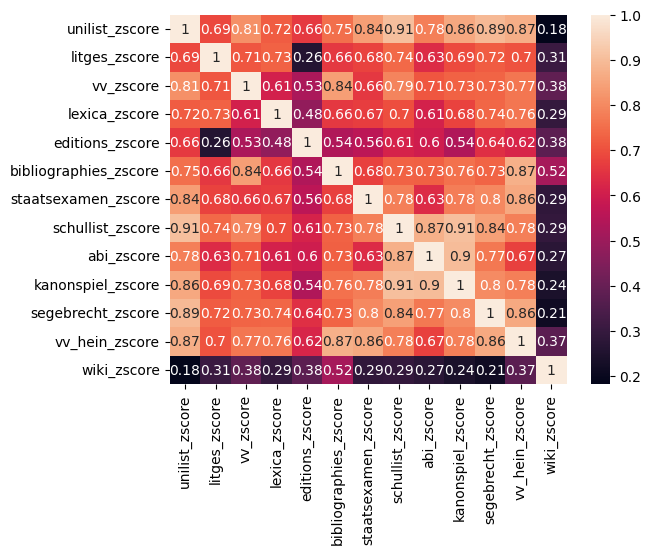

In [25]:
corr_results = (
    data
    .query("canonicity_score_rank <= 50")
    [[x+'_zscore' for x in all_indicator_dict.keys()]]
    .apply(zscore)
    .corr(method='pearson')
    # .pipe(anonymize)
)

sns.heatmap(corr_results, annot=True)

In [26]:
thresholds = range(50, 6000, 50)

fig = go.Figure()

# add a scatter trace for each threshold
for i, t in enumerate(thresholds):
    filtered = (
        data
        .query(f"canonicity_score_rank <= {t}")
        [[x+'_zscore' for x in all_indicator_dict.keys()]]
        .apply(zscore)
        # .pipe(anonymize)
        .T
    )    
    components = PCA(n_components=2).fit_transform(filtered)
    
    fig.add_trace(go.Scatter(
        x=components[:, 0],
        y=components[:, 1],
        mode='markers+text',
        text=filtered.index,
        textposition='top center',
        marker=dict(size=8),
        name=f'Top {t}',
        visible=(i==0)  # only show the first initially
    ))

# create slider steps: each step makes only one trace visible
steps = []
for i, t in enumerate(thresholds):
    step = dict(
        method='update',
        args=[{'visible': [j == i for j in range(len(thresholds))]}],
        label=f'Top {t}'
    )
    steps.append(step)

# add slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Threshold: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [27]:
# Build lists: primary indicators and zscored secondary indicators
primary_indicators = [item+'_zscore' for item in list(all_indicator_dict.keys())]
secondary_indicators = [item+'_zscore' for sublist in all_indicator_dict.values() for item in sublist]

# All columns we need
all_columns = primary_indicators + secondary_indicators

# Filter data (here you can also apply your rank cutoff if you want)
data_compare = data.query("canonicity_score_rank<=999999999")[all_columns]

# Transpose so each column becomes a point in PCA
data_t = data_compare.T

# Run PCA
pca = PCA(n_components=2)
components = pca.fit_transform(data_t)

# Create DataFrame
pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
pca_df['label'] = data_t.index


# Identify group and type
def find_group(label):
    # Remove '_zscore' suffix for matching
    original = label[:-7]  # strip '_zscore'
    
    if original in all_indicator_dict:  # Ensure it's in the dictionary keys (for primary)
        return original  # The primary indicator will return as its own group
    else:
        for group, sublist in all_indicator_dict.items():
            if original in sublist:
                return group
        return 'unknown'

def find_type(label):
    if label in primary_indicators:
        return 'primary'
    else:
        return 'secondary'

pca_df['group'] = pca_df['label'].apply(find_group)
pca_df['type'] = pca_df['label'].apply(find_type)

# Colors: one color per group
group_colors = px.colors.qualitative.Set1
unique_groups = list(all_indicator_dict.keys())
color_map = {group: group_colors[i % len(group_colors)] for i, group in enumerate(unique_groups)}

# Build figure
fig = go.Figure()

# Plot secondary indicators (only if group has more than one secondary), smaller, no outline
for group in unique_groups:
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'secondary')]
    
    if len(subset) > 1:
        fig.add_trace(go.Scatter(
            x=subset['PC1'],
            y=subset['PC2'],
            mode='markers',
            text=subset['label'],
            hoverinfo='text',
            marker=dict(size=8, color=color, line=dict(width=0)),
            name=f'{group} secondary'
        ))

# Plot primary indicators (larger, black ring)
for i, group in enumerate(unique_groups):
    color = color_map[group]
    subset = pca_df[(pca_df['group'] == group) & (pca_df['type'] == 'primary')]
    fig.add_trace(go.Scatter(
        x=subset['PC1'],
        y=subset['PC2'],
        mode='markers+text', # 👈 switch to markers+text to de-anonymize
        text=subset['label'],
        textposition='top center',
        marker=dict(size=12, color=color, line=dict(width=2, color='black')),
        name=f'{group} primary',  # Unique name for the legend
        showlegend=False  # hide primary from legend
    ))

# Update layout to ensure legend and visibility
fig.update_layout(
    width=900,
    height=700,
    showlegend=True  # 👈 switch to True to de-anonymize
)

# Show the plot
fig.show()



# Vermutungen zu Indikatorenvergleich

In [28]:
primary_indicators = list(all_indicator_dict.keys())
secondary_indicators = [item for sublist in all_indicator_dict.values() for item in sublist]
all_indicators = primary_indicators + secondary_indicators

academic_primary_indicators = list(academic_indicator_dict.keys())
nonacademic_primary_indicators = list(other_indicator_dict.keys())
academic_primary_indicators_zscore = [x+'_zscore' for x in academic_primary_indicators]
nonacademic_primary_indicators_zscore = [x+'_zscore' for x in nonacademic_primary_indicators]

In [29]:
def create_corr_table(data, indicator_type = 'all', top_authors = 9999, method = 'pearson', delete_cross = True):
    data = data.query("canonicity_score_rank <= @top_authors")

    if indicator_type == 'all':
        relevant_columns = [x+'_zscore' for x in all_indicators]
    elif indicator_type == 'primary':
        relevant_columns = [x+'_zscore' for x in primary_indicators]
    elif indicator_type == 'secondary':
        relevant_columns = [x+'_zscore' for x in secondary_indicators]
    data = data[relevant_columns]

    data = data.apply(zscore)

    corr_results = data.corr(method = method)

    if delete_cross:
        mask = ~np.eye(corr_results.shape[0], dtype=bool)
        corr_results = corr_results.where(mask)

    return corr_results

In [30]:
corr_primary_all_pearson = create_corr_table(data, indicator_type='primary', top_authors=9999, method='pearson')
corr_primary_all_spearman = create_corr_table(data, indicator_type='primary', top_authors=9999, method='spearman')
corr_primary_top50_pearson = create_corr_table(data, indicator_type='primary', top_authors=50, method='pearson')
corr_primary_top50_spearman = create_corr_table(data, indicator_type='primary', top_authors=50, method='spearman')

corr_tables_primary_dict = {
    'primary_all_pearson' : corr_primary_all_pearson,
    'primary_all_spearman' : corr_primary_all_spearman,
    'primary_top50_pearson' : corr_primary_top50_pearson,
    'primary_top50_spearman' : corr_primary_top50_spearman,
}

corr_secondary_all_pearson = create_corr_table(data, indicator_type='secondary', top_authors=9999, method='pearson')
corr_secondary_all_spearman = create_corr_table(data, indicator_type='secondary', top_authors=9999, method='spearman')
corr_secondary_top50_pearson = create_corr_table(data, indicator_type='secondary', top_authors=50, method='pearson')
corr_secondary_top50_spearman = create_corr_table(data, indicator_type='secondary', top_authors=50, method='spearman')

corr_tables_secondary_dict = {
    'secondary_all_pearson' : corr_secondary_all_pearson,
    'secondary_all_spearman' : corr_secondary_all_spearman,
    'secondary_top50_pearson' : corr_secondary_top50_pearson,
    'secondary_top50_spearman' : corr_secondary_top50_spearman,
}

In [31]:
corr_secondary_all_pearson

,prob_to_read_share_unilist_heidelberg_2017_zscore,prob_to_read_share_unilist_aachen_201718_zscore,prob_to_read_share_unilist_goettingen_zscore,prob_to_read_share_unilist_luxemburg_zscore,prob_to_read_share_unilist_graz_2021_zscore,prob_to_read_share_unilist_saarland_2007_zscore,prob_to_read_share_unilist_magdeburg_2020_zscore,prob_to_read_share_unilist_tuebingen_zscore,prob_to_read_share_unilist_leipzig_zscore,prob_to_read_share_unilist_salzburg_zscore,...,schullist_saarland_share_zscore,schullist_hessen_share_zscore,schullist_bremen_share_zscore,schullist_brandenburg_share_zscore,schullist_badenwuerttemberg_share_zscore,abi_mentions_zscore,kanonspiel_points_zscore,segebrecht_count_zscore,vv_hein_count_zscore,wiki_length_in_words_zscore
prob_to_read_share_unilist_heidelberg_2017_zscore,NaN,0.639188,0.843497,0.804122,0.644149,0.738377,0.718641,0.821016,0.607948,0.766861,...,0.601823,0.696519,0.579662,0.469783,0.762213,0.805835,0.813937,0.801678,0.838200,0.359334
prob_to_read_share_unilist_aachen_201718_zscore,0.639188,NaN,0.613852,0.597081,0.609480,0.618091,0.611027,0.594408,0.610172,0.602157,...,0.441437,0.488286,0.430497,0.367875,0.595516,0.547904,0.576180,0.631855,0.666098,0.331518
prob_to_read_share_unilist_goettingen_zscore,0.843497,0.613852,NaN,0.801540,0.611699,0.707064,0.737554,0.774538,0.523361,0.731624,...,0.559972,0.667493,0.609544,0.390316,0.709641,0.773723,0.792027,0.793642,0.830216,0.360495
prob_to_read_share_unilist_luxemburg_zscore,0.804122,0.597081,0.801540,NaN,0.597029,0.723013,0.686799,0.715648,0.536771,0.694414,...,0.548519,0.589737,0.599028,0.401949,0.656886,0.700990,0.711815,0.740516,0.803940,0.355586
prob_to_read_share_unilist_graz_2021_zscore,0.644149,0.609480,0.611699,0.597029,NaN,0.679839,0.678482,0.728128,0.625203,0.710543,...,0.480090,0.577467,0.378718,0.323562,0.656690,0.536837,0.715744,0.659770,0.645725,0.377218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
abi_mentions_zscore,0.805835,0.547904,0.773723,0.700990,0.536837,0.605773,0.639448,0.707668,0.463505,0.621314,...,0.624734,0.757088,0.533705,0.494406,0.733374,NaN,0.843913,0.712464,0.738323,0.315230
kanonspiel_points_zscore,0.813937,0.576180,0.792027,0.711815,0.715744,0.720949,0.754298,0.791321,0.598131,0.717004,...,0.688978,0.807848,0.550641,0.402667,0.793439,0.843913,NaN,0.793746,0.802484,0.412523
segebrecht_count_zscore,0.801678,0.631855,0.793642,0.740516,0.659770,0.807969,0.820567,0.776531,0.581111,0.729083,...,0.591867,0.720776,0.507215,0.349170,0.772363,0.712464,0.793746,NaN,0.812873,0.445923
vv_hein_count_zscore,0.838200,0.666098,0.830216,0.803940,0.645725,0.752398,0.689330,0.736700,0.647840,0.724379,...,0.504304,0.626777,0.664863,0.371996,0.685078,0.738323,0.802484,0.812873,NaN,0.396260


primary_all_pearson


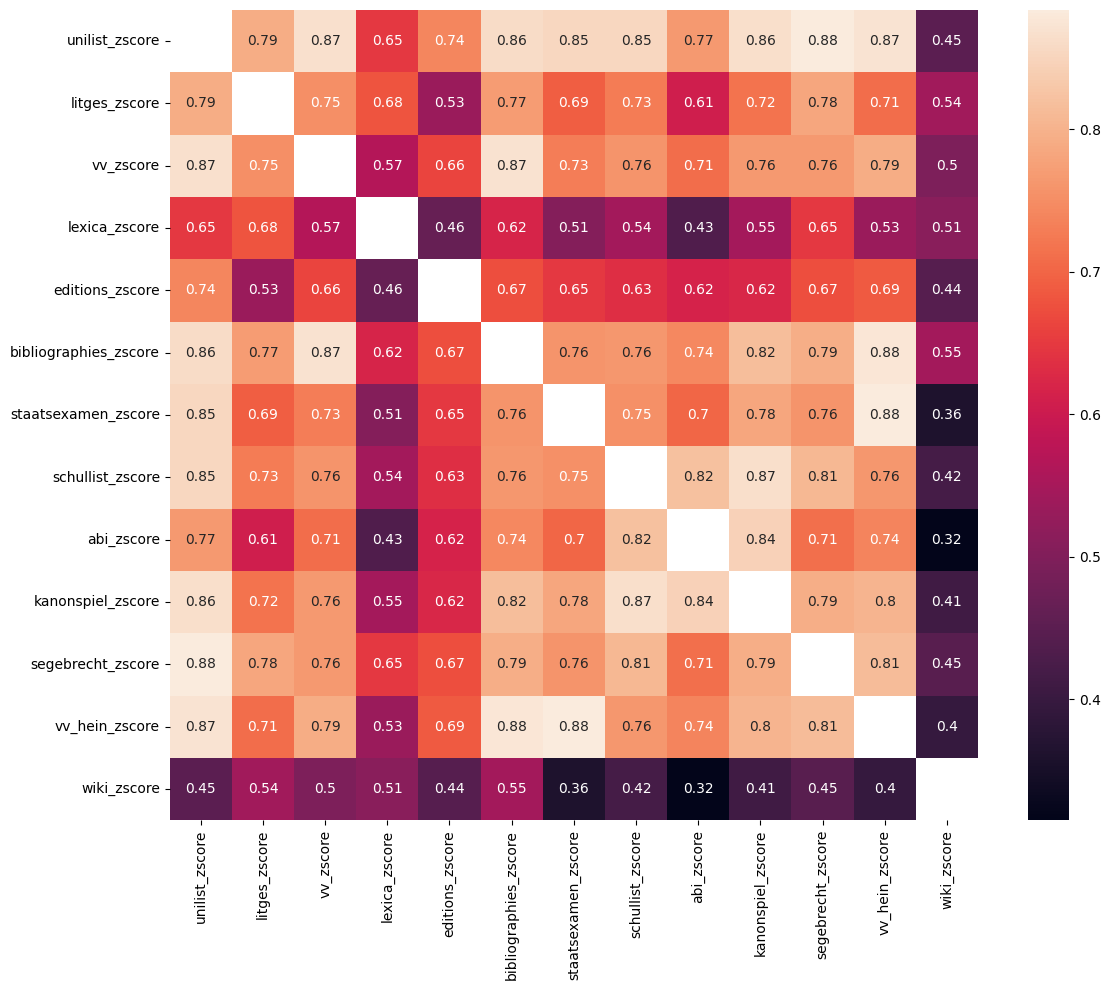

primary_all_spearman


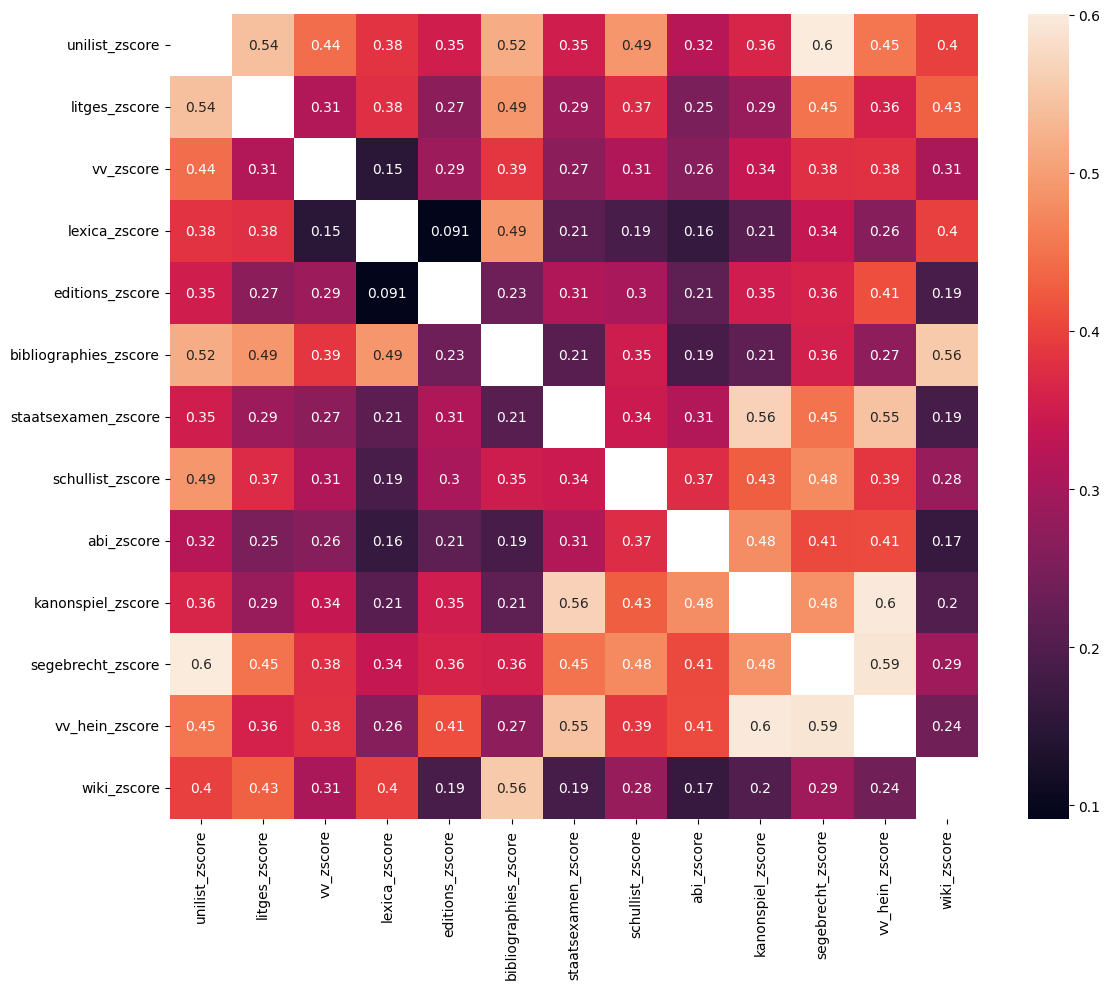

primary_top50_pearson


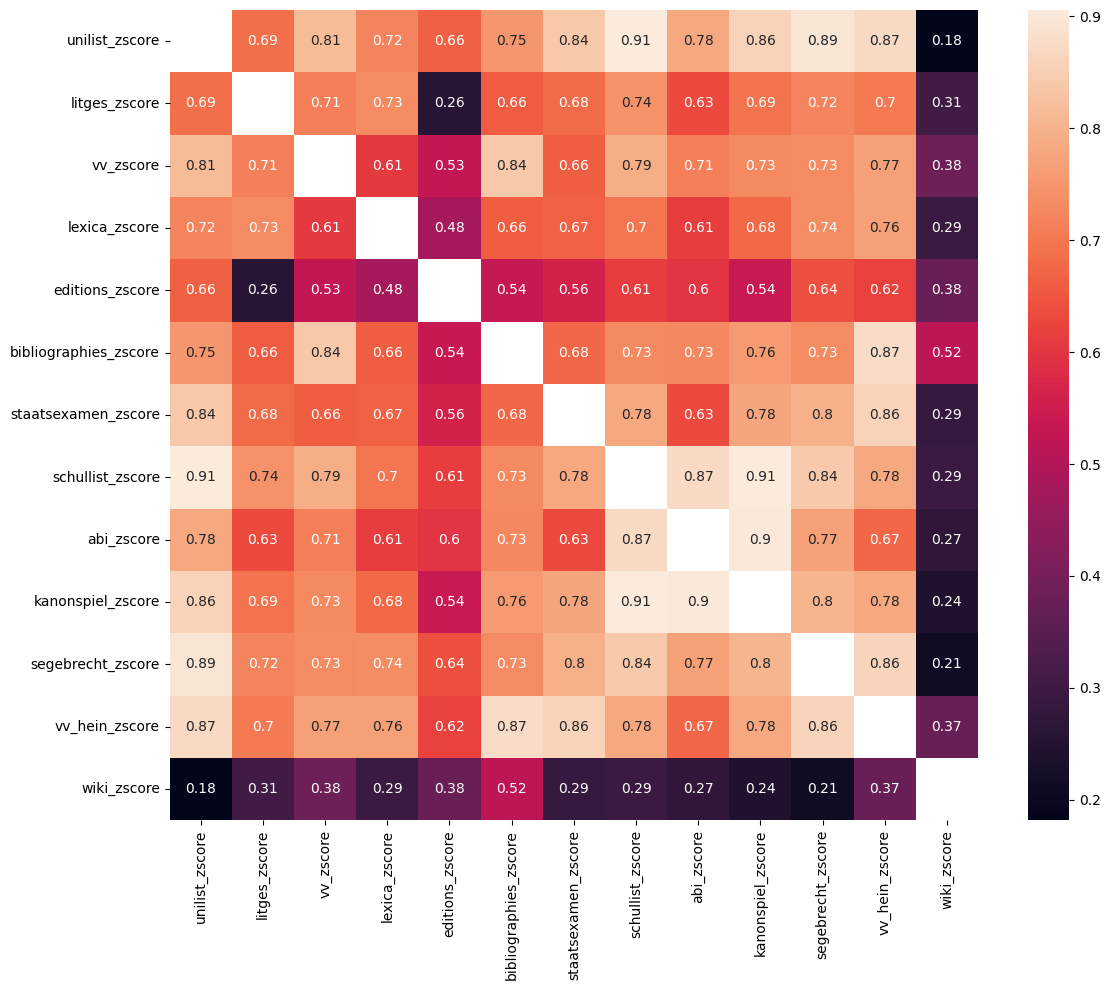

primary_top50_spearman


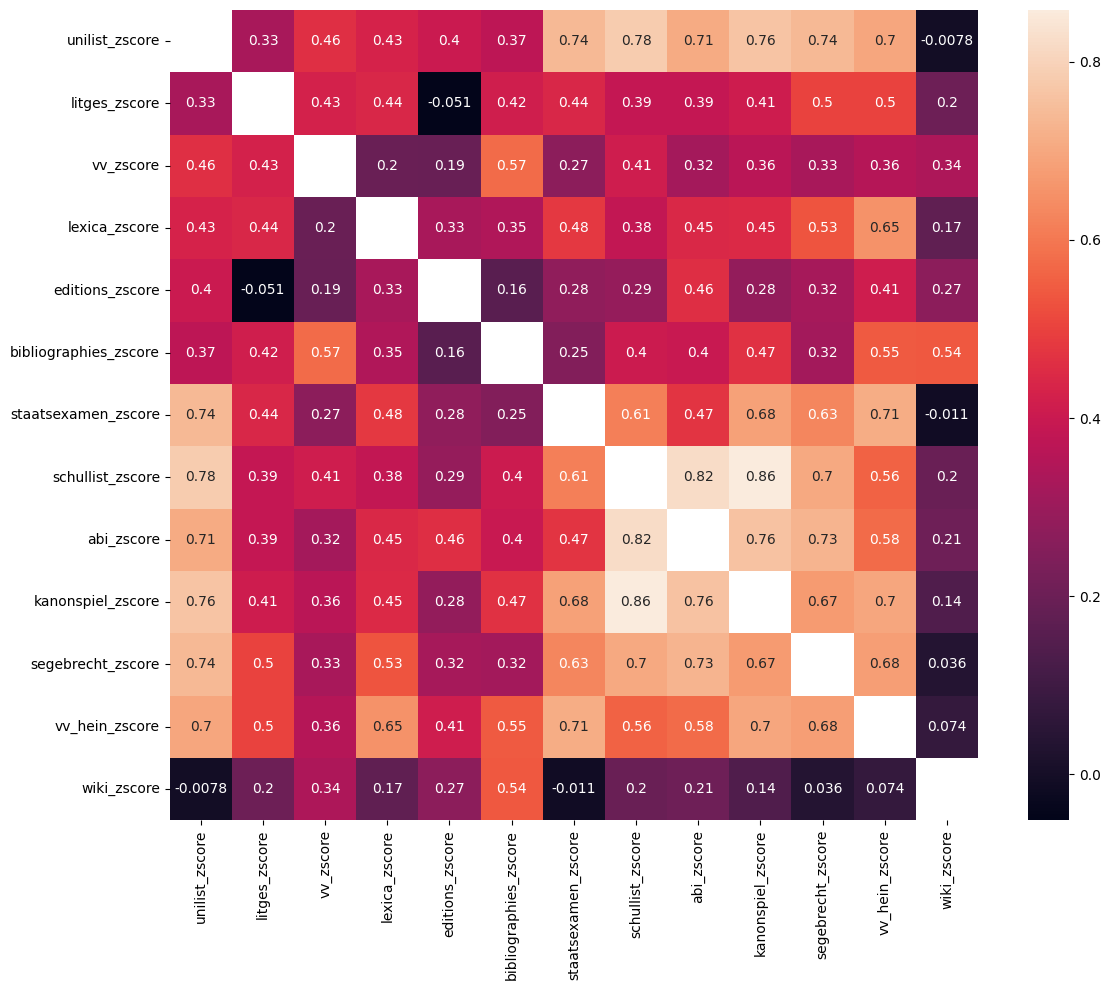

In [32]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    print(corr_table_name)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_table, annot=True)
    plt.tight_layout()
    plt.show()

### (1) alle korrelieren positiv miteinander

Operationalisierung: Sind alle Korrelationen zwischen primären Indiaktoren positiv und größer als 0? 

Ergebnis: trifft (fast immmer) zu (einzige Ausnahmen: einige Korrelationen bei primary_top50_spearman)

In [33]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_table_unstacked = corr_table.stack().reset_index()
    corr_table_unstacked.columns = ['var1', 'var2', 'value']
    corr_table_unstacked = corr_table_unstacked[corr_table_unstacked['var1'] < corr_table_unstacked['var2']].reset_index(drop=True)

    print(corr_table_name)
    print("5 lowest correlations:")
    print(f"{corr_table_unstacked.sort_values(by='value').head(5).values}")
    print("\n")

primary_all_pearson
5 lowest correlations:
[['abi_zscore' 'wiki_zscore' 0.3152304528381166]
 ['staatsexamen_zscore' 'wiki_zscore' 0.3604599053135926]
 ['vv_hein_zscore' 'wiki_zscore' 0.39625969892654217]
 ['kanonspiel_zscore' 'wiki_zscore' 0.4125227417390518]
 ['schullist_zscore' 'wiki_zscore' 0.41911595944810986]]


primary_all_spearman
5 lowest correlations:
[['editions_zscore' 'lexica_zscore' 0.09121848386844421]
 ['lexica_zscore' 'vv_zscore' 0.1477637457080703]
 ['abi_zscore' 'lexica_zscore' 0.16392161583034084]
 ['abi_zscore' 'wiki_zscore' 0.16619329836907346]
 ['staatsexamen_zscore' 'wiki_zscore' 0.18651022981782256]]


primary_top50_pearson
5 lowest correlations:
[['unilist_zscore' 'wiki_zscore' 0.18168931780785594]
 ['segebrecht_zscore' 'wiki_zscore' 0.21495694730843196]
 ['kanonspiel_zscore' 'wiki_zscore' 0.2413397300446666]
 ['editions_zscore' 'litges_zscore' 0.25933316876012835]
 ['abi_zscore' 'wiki_zscore' 0.27417281791626885]]


primary_top50_spearman
5 lowest correlations

### (2) höhere Korrelationen innerhalb akademisch als mit anderen

Operationalisierung: Ist Durchschnitt der Korrelationen innerhalb primärer akademischer Indikatoren größer als Durchschnitt der Korrelationen zwischen primären akademischen Indikatoren und primären nicht-akademischen Indikatoren?

Ergebnis: nein oder höchstens minimal

In [34]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_academic_within = corr_table.loc[academic_primary_indicators_zscore, academic_primary_indicators_zscore].mean().mean()
    corr_other_within = corr_table.loc[nonacademic_primary_indicators_zscore, nonacademic_primary_indicators_zscore].mean().mean()
    corr_academic_other = corr_table.loc[academic_primary_indicators_zscore, nonacademic_primary_indicators_zscore].mean().mean()

    print(corr_table_name)
    print(f"mean corr within academic                  : {corr_academic_within}")
    print(f"mean corr within nonacademic               : {corr_other_within}")
    print(f"mean corr between academic and nonacademic : {corr_academic_other}")
    print("\n")

primary_all_pearson
mean corr within academic                  : 0.6999464027354767
mean corr within nonacademic               : 0.6754670337838268
mean corr between academic and nonacademic : 0.6825921712439581


primary_all_spearman
mean corr within academic                  : 0.3554283370895419
mean corr within nonacademic               : 0.39137731281497323
mean corr between academic and nonacademic : 0.3270229323110413


primary_top50_pearson
mean corr within academic                  : 0.6433507179995918
mean corr within nonacademic               : 0.6533482516991995
mean corr between academic and nonacademic : 0.6668829285936985


primary_top50_spearman
mean corr within academic                  : 0.33457776885643553
mean corr within nonacademic               : 0.5140704809390634
mean corr between academic and nonacademic : 0.4279226942152202




### (3) wiki unähnlicher zu anderen Indikatoren

Operationalisierung: Ist Durchschnitt der Korrelationen zwischen wiki und allen anderen primären Indikatoren kleiner als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [35]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()

    results = pd.DataFrame()
    for primary_indicator in primary_indicators:
        results.at[primary_indicator, 'mean_corr'] = corr_table[primary_indicator+'_zscore'].mean().mean()
    results['mean_corr_rank'] = results['mean_corr'].rank(method='min', ascending=False).astype(int)

    print(corr_table_name)
    print(f"mean corr all       : {all_mean}")
    print(f"mean corr wiki      : {results.at['wiki', 'mean_corr']}")
    print(f"mean corr wiki rank : {results.at['wiki', 'mean_corr_rank']}")
    print("\n")

primary_all_pearson
mean corr all       : 0.6840112172145995
mean corr wiki      : 0.4449323427345586
mean corr wiki rank : 13


primary_all_spearman
mean corr all       : 0.3498116895195039
mean corr wiki      : 0.30386011353515013
mean corr wiki rank : 10


primary_top50_pearson
mean corr all       : 0.6587135520078514
mean corr wiki      : 0.312480820862443
mean corr wiki rank : 13


primary_top50_spearman
mean corr all       : 0.4331653819180271
mean corr wiki      : 0.17955644102722965
mean corr wiki rank : 13




### (4) vv_hein unähnlicher zu den anderen

Operationalisierung: Ist Durchschnitt der Korrelationen zwischen vv_hein und allen anderen primären Indikatoren kleiner als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: nein

In [36]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()

    results = pd.DataFrame()
    for primary_indicator in primary_indicators:
        results.at[primary_indicator, 'mean_corr'] = corr_table[primary_indicator+'_zscore'].mean().mean()
    results['mean_corr_rank'] = results['mean_corr'].rank(method='min', ascending=False).astype(int)

    print(corr_table_name)
    print(f"mean corr all          : {all_mean}")
    print(f"mean corr vv_hein      : {results.at['vv_hein', 'mean_corr']}")
    print(f"mean corr vv_hein rank : {results.at['vv_hein', 'mean_corr_rank']}")
    print("\n")

primary_all_pearson
mean corr all          : 0.6840112172145995
mean corr vv_hein      : 0.7387032124366216
mean corr vv_hein rank : 4


primary_all_spearman
mean corr all          : 0.3498116895195039
mean corr vv_hein      : 0.4092102683896392
mean corr vv_hein rank : 3


primary_top50_pearson
mean corr all          : 0.6587135520078514
mean corr vv_hein      : 0.744310927305304
mean corr vv_hein rank : 3


primary_top50_spearman
mean corr all          : 0.4331653819180271
mean corr vv_hein      : 0.5379518638215072
mean corr vv_hein rank : 2




### (5) Bereich Schule untereinander ähnlich, Bereich akademisch untereinander ähnlich

'Bereich akademisch untereinander ähnlich' schon durch (2) geprüft, also Fokus auf 'Bereich Schule untereinander ähnlich'

Operationalisierung: Ist die Korrelation zwischen abi und schullist größer als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [37]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()
    corr_abi_schullist = corr_table.loc['abi_zscore', 'schullist_zscore']

    print(corr_table_name)
    print(f"mean corr all       : {all_mean}")
    print(f"corr abi<>schullist : {corr_abi_schullist}")
    print("\n")

primary_all_pearson
mean corr all       : 0.6840112172145995
corr abi<>schullist : 0.8191861863690246


primary_all_spearman
mean corr all       : 0.3498116895195039
corr abi<>schullist : 0.37375416406709583


primary_top50_pearson
mean corr all       : 0.6587135520078514
corr abi<>schullist : 0.8733694576075365


primary_top50_spearman
mean corr all       : 0.4331653819180271
corr abi<>schullist : 0.8198205799419196




### (6) editionen (reclam) zwischen Bereich Schule und akademisch

Operationalisierung: Sind der Durchschnitt der Korrelationen zwischen Reclam und Abi/Schullist und der Durchschnitt der Korrelationen zwischen Reclam und BDSL/Killy/LitGes/VV/Unilist größer als der Durchschnitt der Korrelationen zwischen Abi/Schullist und BDSL/Killy/LitGes/VV/Unilist?

Ergebnis: nein

In [38]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    mean_corr_reclam_school = np.mean([
        corr_table.at['editions_zscore', 'abi_zscore'],
        corr_table.at['editions_zscore', 'schullist_zscore']
        ])
    mean_corr_reclam_academic = np.mean([
        corr_table.at['editions_zscore', 'bibliographies_zscore'],
        corr_table.at['editions_zscore', 'litges_zscore'],
        corr_table.at['editions_zscore', 'vv_zscore'],
        corr_table.at['editions_zscore', 'unilist_zscore'],
        corr_table.at['editions_zscore', 'lexica_zscore'],
        ])
    mean_corr_school_academic = np.mean([
        corr_table.at['abi_zscore', 'bibliographies_zscore'],
        corr_table.at['abi_zscore', 'litges_zscore'],
        corr_table.at['abi_zscore', 'vv_zscore'],
        corr_table.at['abi_zscore', 'unilist_zscore'],
        corr_table.at['abi_zscore', 'lexica_zscore'],

        corr_table.at['schullist_zscore', 'bibliographies_zscore'],
        corr_table.at['schullist_zscore', 'litges_zscore'],
        corr_table.at['schullist_zscore', 'vv_zscore'],
        corr_table.at['schullist_zscore', 'unilist_zscore'],
        corr_table.at['schullist_zscore', 'lexica_zscore'],
    ])

    print(corr_table_name)
    print(f"mean corr reclam<>school   : {mean_corr_reclam_school}")
    print(f"mean corr reclam<>academic : {mean_corr_reclam_academic}")
    print(f"mean corr school<>academic : {mean_corr_school_academic}")
    print("\n")

primary_all_pearson
mean corr reclam<>school   : 0.6249261639063125
mean corr reclam<>academic : 0.6153144966565677
mean corr school<>academic : 0.690334751990957


primary_all_spearman
mean corr reclam<>school   : 0.2592223168582438
mean corr reclam<>academic : 0.24776121145593016
mean corr school<>academic : 0.28977069046018467


primary_top50_pearson
mean corr reclam<>school   : 0.6069651615008005
mean corr reclam<>academic : 0.4936252493740261
mean corr school<>academic : 0.7336233368039718


primary_top50_spearman
mean corr reclam<>school   : 0.3736234840536888
mean corr reclam<>academic : 0.20583771785134428
mean corr school<>academic : 0.46193833522791194




### (7) staatsexamen zwischen Bereich Schule und akademisch

Operationalisierung: Sind der Durchschnitt der Korrelationen zwischen Staatsexamen und Abi/Schullist und der Durchschnitt der Korrelationen zwischen Staatsexamen und BDSL/Killy/LitGes/VV/Unilist größer als der Durchschnitt der Korrelationen zwischen Abi/Schullist und BDSL/Killy/LitGes/VV/Unilist?

Ergebnis: nein

In [39]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    mean_corr_staatsexamen_school = np.mean([
        corr_table.at['staatsexamen_zscore', 'abi_zscore'],
        corr_table.at['staatsexamen_zscore', 'schullist_zscore']
        ])
    mean_corr_staatsexamen_academic = np.mean([
        corr_table.at['staatsexamen_zscore', 'bibliographies_zscore'],
        corr_table.at['staatsexamen_zscore', 'litges_zscore'],
        corr_table.at['staatsexamen_zscore', 'vv_zscore'],
        corr_table.at['staatsexamen_zscore', 'unilist_zscore'],
        corr_table.at['staatsexamen_zscore', 'lexica_zscore'],
        ])
    mean_corr_school_academic = np.mean([
        corr_table.at['abi_zscore', 'bibliographies_zscore'],
        corr_table.at['abi_zscore', 'litges_zscore'],
        corr_table.at['abi_zscore', 'vv_zscore'],
        corr_table.at['abi_zscore', 'unilist_zscore'],
        corr_table.at['abi_zscore', 'lexica_zscore'],

        corr_table.at['schullist_zscore', 'bibliographies_zscore'],
        corr_table.at['schullist_zscore', 'litges_zscore'],
        corr_table.at['schullist_zscore', 'vv_zscore'],
        corr_table.at['schullist_zscore', 'unilist_zscore'],
        corr_table.at['schullist_zscore', 'lexica_zscore'],
    ])

    print(corr_table_name)
    print(f"mean corr staatsexamen<>school   : {mean_corr_staatsexamen_school}")
    print(f"mean corr staatsexamen<>academic : {mean_corr_staatsexamen_academic}")
    print(f"mean corr school<>academic       : {mean_corr_school_academic}")
    print("\n")

primary_all_pearson
mean corr staatsexamen<>school   : 0.7274845486411768
mean corr staatsexamen<>academic : 0.7070365334652647
mean corr school<>academic       : 0.690334751990957


primary_all_spearman
mean corr staatsexamen<>school   : 0.32931476570824025
mean corr staatsexamen<>academic : 0.26674082381811404
mean corr school<>academic       : 0.28977069046018467


primary_top50_pearson
mean corr staatsexamen<>school   : 0.7067357622544693
mean corr staatsexamen<>academic : 0.7048814994883132
mean corr school<>academic       : 0.7336233368039718


primary_top50_spearman
mean corr staatsexamen<>school   : 0.5426643570871114
mean corr staatsexamen<>academic : 0.43513648703616914
mean corr school<>academic       : 0.46193833522791194




### (8) evtl. Ähnlichkeit Hein-Staatsexamen (?)

Operationalisierung: Ist die Korrelation zwischen staatsexamen und vv_hein größer als der Durchschnitt der Korrelationen zwischen allen primären Indikatoren?

Ergebnis: ja

In [40]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    all_mean = corr_table.mean().mean()
    corr_staatsexamen_hein = corr_table.loc['staatsexamen_zscore', 'vv_hein_zscore']

    print(corr_table_name)
    print(f"mean corr all              : {all_mean}")
    print(f"corr staatsexamen<>vv_hein : {corr_staatsexamen_hein}")
    print("\n")

primary_all_pearson
mean corr all              : 0.6840112172145995
corr staatsexamen<>vv_hein : 0.8834579276689332


primary_all_spearman
mean corr all              : 0.3498116895195039
corr staatsexamen<>vv_hein : 0.5464351438786321


primary_top50_pearson
mean corr all              : 0.6587135520078514
corr staatsexamen<>vv_hein : 0.8581817336509889


primary_top50_spearman
mean corr all              : 0.4331653819180271
corr staatsexamen<>vv_hein : 0.711128049369369




### (9) Goethe immer ‘kanonischster’ Autor

Operationalisierung: Für jeden primären Indikator schauen, ob Goethe kanonischster Autor ist

Ergebnis: fast immer

In [41]:
for primary_indicator in primary_indicators:
    primary_indicator_top5 = data.sort_values(by=f'{primary_indicator}_zscore', ascending=False).head(5)
    primary_indicator_top5 = primary_indicator_top5[['GND_name', primary_indicator+'_zscore']]
    print(primary_indicator)
    print(primary_indicator_top5.values)
    print("\n")

unilist
[['Goethe, Johann Wolfgang von' 35.94730946148402]
 ['Schiller, Friedrich' 22.400840679717188]
 ['Kleist, Heinrich von' 17.519985200446698]
 ['Brecht, Bertolt' 16.358208319710297]
 ['Lessing, Gotthold Ephraim' 15.484890390562201]]


litges
[['Brecht, Bertolt' 27.226308684397978]
 ['Goethe, Johann Wolfgang von' 24.6368234686549]
 ['Schiller, Friedrich' 18.29962296256592]
 ['Mann, Thomas' 16.723860392295247]
 ['Lessing, Gotthold Ephraim' 12.133085214751933]]


vv
[['Goethe, Johann Wolfgang von' 35.453708446058045]
 ['Brecht, Bertolt' 21.607239817466315]
 ['Schiller, Friedrich' 18.736934876742176]
 ['Kafka, Franz' 18.17825583055064]
 ['Kleist, Heinrich von' 14.509290475846878]]


lexica
[['Goethe, Johann Wolfgang von' 15.116335139096606]
 ['Schiller, Friedrich' 12.578845866505095]
 ['Brecht, Bertolt' 10.601257422961126]
 ['Hölderlin, Friedrich' 10.28777534318799]
 ['Thomasius, Christian' 10.169244805562325]]


editions
[['Goethe, Johann Wolfgang von' 29.746140614775133]
 ['Schille

### (10) stark von männlichen Autoren definiert, aber unterschiedlich je nach:

#### (a) Welche Epoche (Geburtsdatum der Autoren)

Operationalisierung: Binning der Autor:innen nach Geburtsdatum, dann für die jeweiligen Bins Gender-Anteil anschauen und prüfen, ob er ansteigt

Ergebnis: ja (besonders 20. Jh.)

In [42]:
results = []

for birth_range_start in range(1500, 2050, 50):
    birth_range_end = birth_range_start + 50
    data_time = data.query("GND_birth >= @birth_range_start and GND_birth < @birth_range_end")

    author_count = len(data_time)
    female_count = (data_time["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    data_time_top200 = data_time.sort_values(by='canonicity_score_rank').head(200)
    female_top200_count = (data_time_top200["GND_gender"] == "Weiblich").sum()
    female_top200_share = female_top200_count / len(data_time_top200) if len(data_time_top200) > 0 else None

    results.append({
        "birth_range_start": birth_range_start,
        "birth_range_end": birth_range_end,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share,
        "female_top200_count": female_top200_count,
        "female_top200_share": female_top200_share
    })

# Final DataFrame
gender_time_results = pd.DataFrame(results)

display(gender_time_results)

,birth_range_start,birth_range_end,author_count,female_count,female_share,female_top200_count,female_top200_share
0,1500,1550,0,0,NaN,0,NaN
1,1550,1600,109,0,0.000000,0,0.000000
2,1600,1650,184,16,0.086957,16,0.086957
3,1650,1700,124,7,0.056452,7,0.056452
4,1700,1750,325,16,0.049231,11,0.055000
5,1750,1800,587,70,0.119250,26,0.130000
6,1800,1850,535,80,0.149533,30,0.150000
7,1850,1900,1244,198,0.159164,24,0.120000
8,1900,1950,1559,292,0.187300,34,0.170000
9,1950,2000,641,228,0.355694,60,0.300000


#### (b) Datum der Daten (vv_hein, staatsexamen mehr männer als heutige Indikatoren)

Operationalisierung: Testen, ob in vv_hein höherer Anteil der Autor:innen männlich ist als in Median der anderen Indikatoren

Ergebnis: ja, vv_hein und staatsexamen haben niedrigsten Frauenanteil überhaupt

In [43]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

,primary_indicator,author_count,female_count,female_share
6,staatsexamen,105,4,0.038095
11,vv_hein,150,14,0.093333
10,segebrecht,287,33,0.114983
8,abi,72,9,0.125000
9,kanonspiel,86,11,0.127907
3,lexica,4811,725,0.150696
4,editions,313,51,0.162939
12,wiki,4968,867,0.174517
5,bibliographies,4070,739,0.181572
1,litges,1180,224,0.189831


#### (c) Schule ‘männlicher’ als akademisch

Operationalisierung: Testen, ob in abi + schullist höherer Anteil der Autor:innen männlich ist als in Median der akademischen Indikatoren

Ergebnis: gemischt. abi viertniedrigster Frauenanteil (12,5%), schullist zweithöchster (24%)

In [44]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

,primary_indicator,author_count,female_count,female_share
6,staatsexamen,105,4,0.038095
11,vv_hein,150,14,0.093333
10,segebrecht,287,33,0.114983
8,abi,72,9,0.125000
9,kanonspiel,86,11,0.127907
3,lexica,4811,725,0.150696
4,editions,313,51,0.162939
12,wiki,4968,867,0.174517
5,bibliographies,4070,739,0.181572
1,litges,1180,224,0.189831


#### (d) Österreichisch ‘weiblicher’ als Deutschland

Operationalisierung: Ist Anteil von Frauen in österreichischen Unilisten und Vorlesungsverzeichnissen größer als in deutschen?

Ergebnis: ja bei Unilisten, nicht klar bei Vorlesungsverzeichnissen

In [45]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]
vv_columns = [x for x in data.columns if 'event_count_rel_vv' in x and 'zscore' not in x and 'rank' not in x]

In [46]:
austrian_keywords = ['graz', 'salzburg', 'innsbruck', 'wien']
exclude_deut_keywords = ['luxemburg', 'lausanne', 'zuerich']

unilist_columns_aust = [
    x for x in unilist_columns 
    if any(keyword in x for keyword in austrian_keywords)
]

unilist_columns_deut = [
    x for x in unilist_columns
    if x not in unilist_columns_aust and not any(keyword in x for keyword in exclude_deut_keywords)
]

In [47]:
results = pd.DataFrame()
for unilist_column in unilist_columns:
    unilist_data = data[data[unilist_column] > 0]
    results.at[unilist_column, 'type'] = 'aus' if unilist_column in unilist_columns_aust else 'deut' if unilist_column in unilist_columns_deut else 'other'
    results.at[unilist_column, 'author_count'] = unilist_data.shape[0]
    results.at[unilist_column, 'female_count'] = unilist_data.query("GND_gender == 'Weiblich'").shape[0]
results['female_share'] = results['female_count']/results['author_count']

display(results)
results.groupby('type')['female_share'].mean()

,type,author_count,female_count,female_share
prob_to_read_share_unilist_heidelberg_2017,deut,80.0,9.0,0.112500
prob_to_read_share_unilist_aachen_201718,deut,200.0,28.0,0.140000
prob_to_read_share_unilist_goettingen,deut,50.0,6.0,0.120000
prob_to_read_share_unilist_luxemburg,other,47.0,7.0,0.148936
prob_to_read_share_unilist_graz_2021,aus,70.0,14.0,0.200000
prob_to_read_share_unilist_saarland_2007,deut,209.0,27.0,0.129187
prob_to_read_share_unilist_magdeburg_2020,deut,202.0,40.0,0.198020
prob_to_read_share_unilist_tuebingen,deut,81.0,7.0,0.086420
prob_to_read_share_unilist_leipzig,deut,92.0,16.0,0.173913
prob_to_read_share_unilist_salzburg,aus,168.0,39.0,0.232143


type
aus      0.246048
deut     0.143799
other    0.144794
Name: female_share, dtype: float64

In [48]:
results = pd.DataFrame()
for vv_column in vv_columns:
    vv_data = data[data[vv_column] > 0]
    results.at[vv_column, 'author_count'] = vv_data.shape[0]
    results.at[vv_column, 'female_count'] = vv_data.query("GND_gender == 'Weiblich'").shape[0]
results['female_share'] = results['female_count']/results['author_count']

results

,author_count,female_count,female_share
event_count_rel_vv_mainz,134.0,24.0,0.179104
event_count_rel_vv_stuttgart,326.0,106.0,0.325153
event_count_rel_vv_wien,302.0,90.0,0.298013


#### (e) ah: vv männlicher als unilist; je: vv weiblicher als unilist

Operationalisierung: Testen, ob in vv höherer Anteil der Autor:innen männlich ist als in unilist

Ergebnis: vv weiblicher als unilist

In [49]:
results = []

for primary_indicator, secondary_indicators in all_indicator_dict.items():
    # Collect all GND IDs associated with any of the secondary indicators
    primary_indicator_ids = set()
    for secondary_indicator in secondary_indicators:
        secondary_ids = data.loc[data[secondary_indicator] > 0, 'GND']
        primary_indicator_ids.update(secondary_ids)

    # Filter data for authors matching the primary indicator
    data_prim_indicator = data[data['GND'].isin(primary_indicator_ids)]
    author_count = len(data_prim_indicator)

    # Count female authors
    female_count = (data_prim_indicator["GND_gender"] == "Weiblich").sum()
    female_share = female_count / author_count if author_count > 0 else None

    results.append({
        "primary_indicator": primary_indicator,
        "author_count": author_count,
        "female_count": female_count,
        "female_share": female_share
    })

# Final DataFrame
gender_indicator_results = pd.DataFrame(results)
display(gender_indicator_results.sort_values(by='female_share'))

,primary_indicator,author_count,female_count,female_share
6,staatsexamen,105,4,0.038095
11,vv_hein,150,14,0.093333
10,segebrecht,287,33,0.114983
8,abi,72,9,0.125000
9,kanonspiel,86,11,0.127907
3,lexica,4811,725,0.150696
4,editions,313,51,0.162939
12,wiki,4968,867,0.174517
5,bibliographies,4070,739,0.181572
1,litges,1180,224,0.189831


### (11) Unterschied nach Land (Österreich; Deutschland; Luxemburg; Schweiz)

Operationalisierung: Ist Korrelation von Österreich, Deutschland UNTEREINANDER größer als Korrelation dazwischen bei Unileselisten? 

Ergebnis: ja, leicht

In [50]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]

austrian_keywords = ['graz', 'salzburg', 'innsbruck', 'wien']
exclude_deut_keywords = ['luxemburg', 'lausanne', 'zuerich']

unilist_columns_aust = [
    x for x in unilist_columns 
    if any(keyword in x for keyword in austrian_keywords)
]
unilist_columns_aust_zscore = [x+'_zscore' for x in unilist_columns_aust]

unilist_columns_deut = [
    x for x in unilist_columns
    if x not in unilist_columns_aust and not any(keyword in x for keyword in exclude_deut_keywords)
]
unilist_columns_deut_zscore = [x+'_zscore' for x in unilist_columns_deut]

In [51]:
unilist_corr_table = data[[x+'_zscore' for x in unilist_columns]].corr(method='pearson')

In [52]:
austria_within = unilist_corr_table.loc[unilist_columns_aust_zscore, unilist_columns_aust_zscore].mean().mean()
deut_within = unilist_corr_table.loc[unilist_columns_deut_zscore, unilist_columns_deut_zscore].mean().mean()
austria_deut_between = unilist_corr_table.loc[unilist_columns_aust_zscore, unilist_columns_deut_zscore].mean().mean()

print(f"mean corr within austria              : {austria_within}")
print(f"mean corr within germany              : {deut_within}")
print(f"mean corr between austria and germany : {austria_deut_between}")

mean corr within austria              : 0.7069547530187382
mean corr within germany              : 0.6693400681751518
mean corr between austria and germany : 0.6243217439625535


### (12) Unterschied Foschung-Lehre (unilist nah an vv; weiter weg von BDSL)

Operationalisierung: Ist die Korrelation zwischen unilist und vv größer als die Korrelationen zwischen unilist und BDSL und vv und BDSL?

Ergebnis: nein. vv oft ziemlich nah an bdsl

In [53]:
for corr_table_name, corr_table in corr_tables_primary_dict.items():
    corr_unilist_vv = corr_table.loc['unilist_zscore', 'vv_zscore']
    corr_unilist_bdsl = corr_table.loc['unilist_zscore', 'bibliographies_zscore']
    corr_bdsl_vv = corr_table.loc['bibliographies_zscore', 'vv_zscore']

    print(corr_table_name)
    print(f"corr unilist<>vv   : {corr_unilist_vv}")
    print(f"corr unilist<>bdsl : {corr_unilist_bdsl}")
    print(f"corr bdsl<>vv      : {corr_bdsl_vv}")
    print("\n")

primary_all_pearson
corr unilist<>vv   : 0.8674513918068287
corr unilist<>bdsl : 0.8608501686062902
corr bdsl<>vv      : 0.8694842377147138


primary_all_spearman
corr unilist<>vv   : 0.44387055054682467
corr unilist<>bdsl : 0.5180912869637935
corr bdsl<>vv      : 0.38732174543706166


primary_top50_pearson
corr unilist<>vv   : 0.8140935600428402
corr unilist<>bdsl : 0.7516731453498855
corr bdsl<>vv      : 0.838303512399679


primary_top50_spearman
corr unilist<>vv   : 0.4618228971901997
corr unilist<>bdsl : 0.37315726290516205
corr bdsl<>vv      : 0.5744333468014109




### (13) vv und unilist von jeweils mainz, stuttgart, wien

Operationalisierung: Ist die Korrelation zwischen unilist_stuttgart und vv_stuttgart, und zwischen unilist_wien und vv_wien größer als der Median der sonstigen Korrelationen zwischen unilist und vv?

Ergebnis: nein

In [54]:
unilist_columns = [x for x in data.columns if 'share_unilist' in x and 'zscore' not in x and 'rank' not in x]
vv_columns = [x for x in data.columns if 'event_count_rel_vv' in x and 'zscore' not in x and 'rank' not in x]

unilist_columns_zscore = [x+'_zscore' for x in unilist_columns]
vv_columns_zscore = [x+'_zscore' for x in vv_columns]

In [55]:
for corr_table_name, corr_table in corr_tables_secondary_dict.items():
    corr_stuttgart_unilist_vv = corr_table.loc['prob_to_read_share_unilist_stuttgart_2022_zscore', 'event_count_rel_vv_stuttgart_zscore']
    corr_wien_unilist_vv = corr_table.loc['prob_to_read_share_unilist_wien_zscore', 'event_count_rel_vv_wien_zscore']
    corr_unilist_vv = corr_table.loc[unilist_columns_zscore, vv_columns_zscore].mean().mean()

    print(corr_table_name)
    print(f"corr stuttgart unilist<>vv   : {corr_stuttgart_unilist_vv}")
    print(f"corr wien      unilist<>vv   : {corr_wien_unilist_vv}")
    print(f"corr all       unilist<>vv   : {corr_unilist_vv}")
    print("\n")

secondary_all_pearson
corr stuttgart unilist<>vv   : 0.7023278053540396
corr wien      unilist<>vv   : 0.4821512056200803
corr all       unilist<>vv   : 0.5987548885112907


secondary_all_spearman
corr stuttgart unilist<>vv   : 0.4603471965659442
corr wien      unilist<>vv   : 0.3473591098295293
corr all       unilist<>vv   : 0.36344157286147194


secondary_top50_pearson
corr stuttgart unilist<>vv   : 0.734634333295536
corr wien      unilist<>vv   : 0.20671432899129588
corr all       unilist<>vv   : 0.4977224720626457


secondary_top50_spearman
corr stuttgart unilist<>vv   : 0.6887054917809416
corr wien      unilist<>vv   : 0.17057799950147196
corr all       unilist<>vv   : 0.32321526764062575


